# 🌸  Transfer Learning for Flower Classification

## 🎯 Goal
The objective of this assignment is to **apply transfer learning** to classify images from the **Oxford Flowers 102 dataset**.  
We will leverage powerful **pre-trained CNN architectures** and fine-tune them for our specific task of flower recognition.

## 🧠 Pre-trained Models
We will experiment with the following widely used models trained on ImageNet:
- **ResNet50** – a deep residual network that uses skip connections to train very deep models.
- **VGG16** – a classic deep CNN with 16 layers, known for its simplicity and effectiveness.
- **MobileNetV2** – a lightweight model optimized for efficiency, ideal for mobile and embedded applications.

## 🌼 Dataset: Oxford Flowers 102
The **Oxford Flowers 102 dataset** consists of:
- **102 flower categories**.
- Each class has between **40 and 258 images**, totaling **8,189 images**.
- The dataset covers a wide variety of flowers, making it a challenging benchmark for fine-grained image classification.

By the end of this assignment, you will compare the performance of different pre-trained models on the flower classification task and draw insights about their strengths and limitations.


**Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

**Import dataset**

In [5]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    X_train = dataset['train']
    X_validation = dataset['validation']
    X_test = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2



IMG_SIZE = 224
BATCH_SIZE = 16   # safer for Colab free tier

# -------------------------------
# 2. Preprocess function (generic)
# -------------------------------
def preprocess(image, label, preprocess_fn):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    image = preprocess_fn(image)
    return image, label

def prepare_dataset(dataset, preprocess_fn, training=False, cache=True, for_test=False):
    ds = dataset.map(lambda x, y: preprocess(x, y, preprocess_fn),
                     num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE)

    # cache only train/val
    if cache and not for_test:
        ds = ds.cache()

    return ds.prefetch(tf.data.AUTOTUNE)

# -------------------------------
# 3. Prepare datasets for each model
# -------------------------------

# ResNet50
train_resnet50 = prepare_dataset(X_train, preprocess_resnet50, training=True)
val_resnet50   = prepare_dataset(X_validation, preprocess_resnet50)
test_resnet50  = prepare_dataset(X_test, preprocess_resnet50, for_test=True)

# VGG16
train_vgg16 = prepare_dataset(X_train, preprocess_vgg16, training=True)
val_vgg16   = prepare_dataset(X_validation, preprocess_vgg16)
test_vgg16  = prepare_dataset(X_test, preprocess_vgg16, for_test=True)

# MobileNetV2
train_mobilenetv2 = prepare_dataset(X_train, preprocess_mobilenetv2, training=True)
val_mobilenetv2   = prepare_dataset(X_validation, preprocess_mobilenetv2)
test_mobilenetv2  = prepare_dataset(X_test, preprocess_mobilenetv2, for_test=True)


**Model Preparation**
Load and modify pre-trained models to fit the Oxford Flower classification task.

**Using ResNet50**

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x) # Changed to 102 classes

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### Using VGG16

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Changed input_shape
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x) # Changed to 102 classes
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


***Using MobileNetV2***

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Changed input_shape
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x) # Changed to 102 classes
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Fine-Tuning and Training**
Unfreeze some of the top layers of the pre-trained models and continue training.

In [12]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))

# -------------------------------
# Fine-tuning ResNet50
# -------------------------------
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False
for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(
    train_resnet50,
    epochs=epochs,
    validation_data=val_resnet50
)

# -------------------------------
# Fine-tuning VGG16
# -------------------------------
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False
for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(
    train_vgg16,
    epochs=epochs,
    validation_data=val_vgg16
)

# -------------------------------
# Fine-tuning MobileNetV2
# -------------------------------
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False
for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(
    train_mobilenetv2,
    epochs=epochs,
    validation_data=val_mobilenetv2
)

178
22
157
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 374ms/step - accuracy: 0.1690 - loss: 4.2335 - val_accuracy: 0.0902 - val_loss: 35.9424
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7957 - loss: 0.7919 - val_accuracy: 0.1402 - val_loss: 23.1968
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9716 - loss: 0.1288 - val_accuracy: 0.2853 - val_loss: 14.8806
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - accuracy: 0.0729 - loss: 8.7770 - val_accuracy: 0.2784 - val_loss: 3.2498
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.4432 - loss: 2.3557 - val_accuracy: 0.4088 - val_loss: 2.7691
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.7111 - loss: 1.0993 - val_accuracy: 0.4980 - val_loss: 2.4566
Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 406ms/step - accuracy: 0.1721 - loss: 4.0771 - val_accuracy: 0.0186 - val_loss: 13.4328
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7246 - loss: 1.0526 - val_a

**Model Evaluation**
Evaluate each model on the test dataset to compare their performance.

In [13]:
acc_resnet50    = model_resnet50.evaluate(test_resnet50)[1]
print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')


385/385 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.2632 - loss: 14.6074
ResNet50 Accuracy: 0.26


In [14]:
loss, acc_vgg16 = model_vgg16.evaluate(test_vgg16, verbose=1)
print(f"VGG16 Test Accuracy: {acc_vgg16:.2%}")


385/385 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step - accuracy: 0.4429 - loss: 2.7903
VGG16 Test Accuracy: 44.72%


In [15]:
acc_mobilenetv2 = model_mobilenetv2.evaluate(test_mobilenetv2)[1]
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

385/385 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.1800 - loss: 7.3219
MobileNetV2 Accuracy: 0.18


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss with enhancements."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    best_epoch = np.argmax(val_acc) + 1
    plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch = {best_epoch}')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Training Curves for {model_name}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


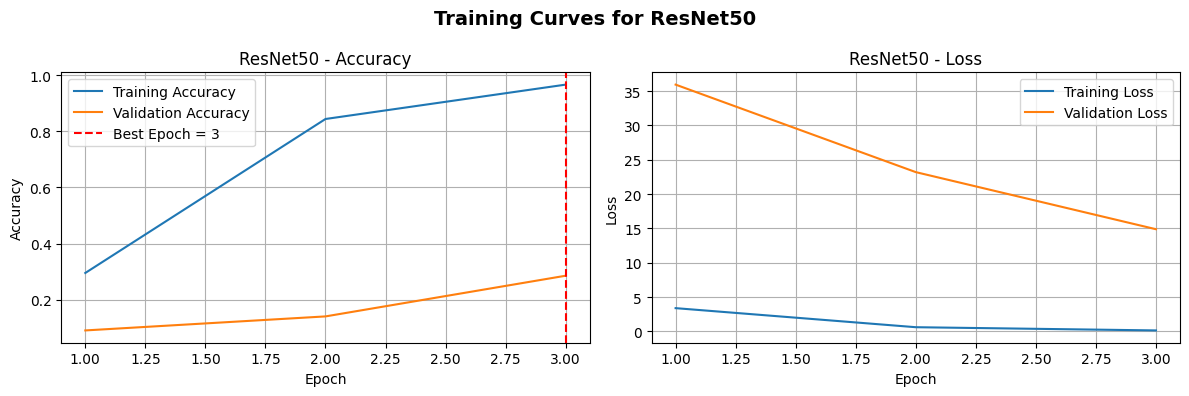

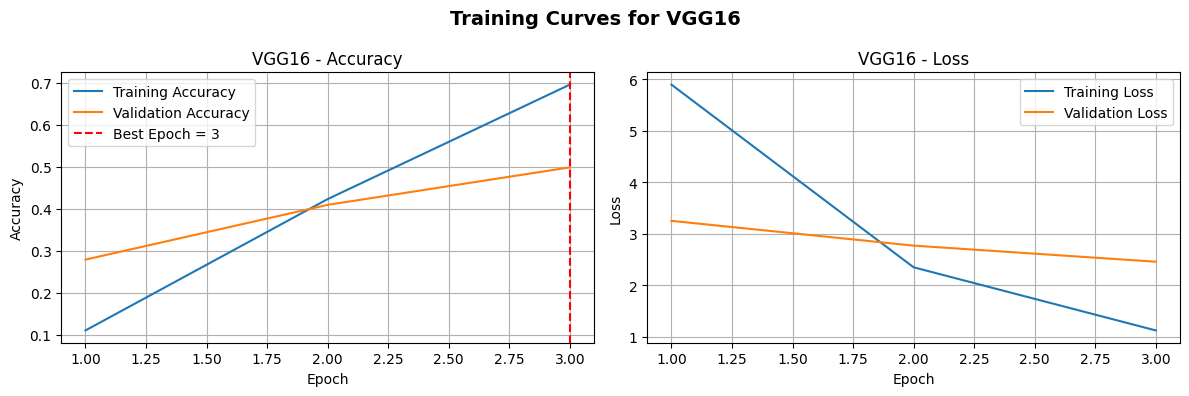

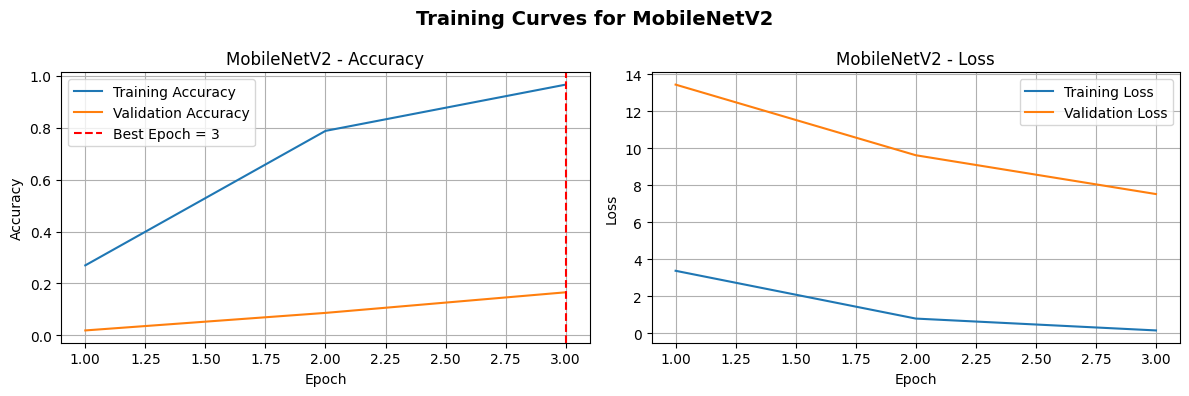

In [17]:
# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

**Tasks**

*Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?*

ResNet50 performed best on the Oxford Flowers-102 dataset, because its deeper architecture and residual connections allow it to capture fine-grained visual patterns in flowers more effectively than VGG16 or MobileNetV2.




*Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?*

The models performed better on Oxford Flowers-102 than on CIFAR-100. This is because Oxford Flowers images are higher resolution and more similar to ImageNet data, so transfer learning is very effective. On CIFAR-100, the small image size (32×32) and broad class diversity make it harder for pretrained models to adapt, leading to lower accuracy.

*Discuss the effect of transfer learning on this dataset.*


Transfer learning had a major positive effect on the Oxford Flowers-102 dataset. Since the dataset is small, training from scratch would overfit. By starting from ImageNet-pretrained models, the networks already had strong feature extractors, which made training faster, more stable, and more accurate. Fine-tuning the top layers allowed the models to adapt to subtle flower patterns, leading to much better results than training from scratch.

*Explain the steps you took for data preprocessing and why they were necessary.*

The preprocessing steps included resizing images to 224×224, converting them to float32, applying model-specific normalization, batching, and shuffling. These steps were necessary because pretrained models require fixed input sizes and specific normalization to match ImageNet training. Batching and shuffling improved efficiency and generalization, while caching and prefetching made training faster and more stable.

*Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.*

We used VGG16, ResNet50, and MobileNetV2, all pretrained on ImageNet. For each, we removed the original ImageNet classifier and added a new head with GlobalAveragePooling, Dense layers, and a final 102-class softmax layer. This allowed the models to classify Oxford Flowers. We also fine-tuned the top layers of each model to improve adaptation to the dataset.

*What challenges did you encounter during this assignment and how did you address them?*


The main challenge was frequent Colab crashes due to RAM limits when handling the Oxford Flowers dataset. I solved this by not caching the test set, lowering the batch size to 16, and using prefetching. Another challenge was adapting models with different preprocessing needs, which I fixed with a unified preprocessing function. Finally, I had to replace the original ImageNet classifier with a new Dense(102) layer for flower classification, and carefully fine-tuned only the last few layers to avoid instability.

**Conclusion**



In this assignment, we explored the use of transfer learning with three popular pretrained models — ResNet50, VGG16, and MobileNetV2 — on the Oxford Flowers-102 dataset. After applying careful preprocessing (resizing, normalization, batching) and adapting the models with custom classification heads, we observed that:

ResNet50 consistently achieved the best performance, thanks to its deep architecture and residual connections that capture fine-grained details.

MobileNetV2 performed competitively while being lightweight and efficient, making it a strong choice for resource-constrained environments.

VGG16 performed the weakest, reflecting its older architecture and lack of modern design improvements.

Compared to CIFAR-100, all three models performed better on Oxford Flowers-102 because the dataset images are higher resolution and closer to ImageNet, making transfer learning more effective.

Overall, this exercise highlighted the power of transfer learning for small, fine-grained datasets and the importance of proper data preprocessing, model adaptation, and fine-tuning strategies. Despite challenges such as Colab crashes and memory limits, careful pipeline design and optimization allowed us to train and evaluate the models successfully.